In [15]:
!pip install pandas
!pip install matplotlib

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

sns.set(style='whitegrid')


In [100]:
# Load your JSON file
with open('user-wallet-transactions.json', 'r') as f:
    data = json.load(f)

print(f"Type of data: {type(data)}")
print(f"Length of data: {len(data)}")
print(f"Sample entry keys: {data[0].keys()}")


Type of data: <class 'list'>
Length of data: 100000
Sample entry keys: dict_keys(['_id', 'userWallet', 'network', 'protocol', 'txHash', 'logId', 'timestamp', 'blockNumber', 'action', 'actionData', '__v', 'createdAt', 'updatedAt'])


In [101]:
# Convert to DataFrame

df = pd.json_normalize(data)
print("Columns available:", df.columns.tolist())
print(df[['userWallet', 'action', 'actionData.type']].head())


Columns available: ['userWallet', 'network', 'protocol', 'txHash', 'logId', 'timestamp', 'blockNumber', 'action', '__v', '_id.$oid', 'actionData.type', 'actionData.amount', 'actionData.assetSymbol', 'actionData.assetPriceUSD', 'actionData.poolId', 'actionData.userId', 'createdAt.$date', 'updatedAt.$date', 'actionData.toId', 'actionData.borrowRateMode', 'actionData.borrowRate', 'actionData.variableTokenDebt', 'actionData.stableTokenDebt', 'actionData.callerId', 'actionData.useATokens', 'actionData.repayerId', 'actionData.liquidatorId', 'actionData.collateralAmount', 'actionData.collateralAssetPriceUSD', 'actionData.principalAmount', 'actionData.borrowAssetPriceUSD', 'actionData.collateralReserveId', 'actionData.collateralReserveSymbol', 'actionData.principalReserveId', 'actionData.principalReserveSymbol']
                                   userWallet            action  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6           deposit   
1  0x000000000051d07a4fb3bd10121a343d85818da6     

In [102]:
print("Columns:", df.columns.tolist())
print("Sample:", df.head(3))


Columns: ['userWallet', 'network', 'protocol', 'txHash', 'logId', 'timestamp', 'blockNumber', 'action', '__v', '_id.$oid', 'actionData.type', 'actionData.amount', 'actionData.assetSymbol', 'actionData.assetPriceUSD', 'actionData.poolId', 'actionData.userId', 'createdAt.$date', 'updatedAt.$date', 'actionData.toId', 'actionData.borrowRateMode', 'actionData.borrowRate', 'actionData.variableTokenDebt', 'actionData.stableTokenDebt', 'actionData.callerId', 'actionData.useATokens', 'actionData.repayerId', 'actionData.liquidatorId', 'actionData.collateralAmount', 'actionData.collateralAssetPriceUSD', 'actionData.principalAmount', 'actionData.borrowAssetPriceUSD', 'actionData.collateralReserveId', 'actionData.collateralReserveSymbol', 'actionData.principalReserveId', 'actionData.principalReserveSymbol']
Sample:                                    userWallet  network protocol  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6  polygon  aave_v2   
1  0x000000000051d07a4fb3bd10121a343d85818da6  polyg

In [103]:
df['amount'] = pd.to_numeric(df['actionData.amount'], errors='coerce')
print(df[['userWallet', 'action', 'amount']].head())


                                   userWallet            action        amount
0  0x00000000001accfa9cef68cf5371a23025b6d4b6           deposit  2.000000e+09
1  0x000000000051d07a4fb3bd10121a343d85818da6           deposit  1.450000e+20
2  0x000000000096026fb41fc39f9875d164bd82e2dc           deposit  1.000000e+15
3  0x000000000096026fb41fc39f9875d164bd82e2dc           deposit  4.000000e+15
4  0x0000000000e189dd664b9ab08a33c4839953852c  redeemunderlying  5.015480e+05


In [104]:
agg = df.groupby('userWallet').agg(
    total_amount=('amount', 'sum'),
    mean_amount=('amount', 'mean'),
    tx_count=('amount', 'count')
).reset_index()


In [105]:
agg['total_deposit'] = df[df['action'].str.lower() == 'deposit'].groupby('userWallet')['amount'].sum()


In [106]:
agg['total_deposit'] = agg['total_deposit'].fillna(0)


In [110]:
agg['credit_score_raw'] = agg['total_deposit'] + (agg['mean_amount'] * 0.1) + (agg['tx_count'] * 0.01)


In [111]:
agg['credit_score_raw'] = agg['credit_score_raw'].clip(lower=0)
agg['credit_score'] = (agg['credit_score_raw'] / agg['credit_score_raw'].max()) * 1000


In [114]:
print(agg[['userWallet', 'credit_score']].sort_values('credit_score', ascending=False).head(20))


                                      userWallet  credit_score
54    0x000f7f22bfc28d940d4b68e13213ab17cf107790   1000.000000
2169  0x03a82ee7997c87e7c6bd227fd3af77a3f175fb91    538.245363
137   0x0034baeeb160a5f1032b6d124d3e87cc94d74e62    527.016924
3317  0x05c824cb84307759b21a29d95b1066a9d1c29cab    238.856842
1499  0x027ffd3c119567e85998f4e6b9c3d83d5702660c    122.180319
3312  0x05c6df5d4cc1158629ffef15d67e34eee73a77b2    110.360545
499   0x00c2e5aa91c2b6927a4e8533482c8217b450a6a1     93.214999
629   0x00fbef9f0f9b0b6421c264a2020f14bca80291ca     84.320983
11    0x00000029ff545c86524ade7caf132527707948c4     80.823873
1733  0x02eca8cc78b7d30c1ac5e16988ed2c8a9da658d6     80.249246
3084  0x055f10edf3684e20dca3c20c063c736da702bcfb     70.310027
2432  0x042cec428c52f9ef51b34d9576a2790d83ed1d0d     59.912977
2205  0x03bd0c6e69bfd5edc3739a7003a9d28c58e57f80     57.171773
1365  0x02491d37984764d39b99e4077649dcd349221a62     56.766459
560   0x00da972a32c522b02771520fb5e70fcb056927fb     55

In [117]:
# Display each user's wallet and their final credit score, sorted descending
agg_sorted = agg[['userWallet', 'credit_score']].sort_values(by='credit_score', ascending=False).reset_index(drop=True)
print(agg_sorted.head(20))  


                                    userWallet  credit_score
0   0x000f7f22bfc28d940d4b68e13213ab17cf107790   1000.000000
1   0x03a82ee7997c87e7c6bd227fd3af77a3f175fb91    538.245363
2   0x0034baeeb160a5f1032b6d124d3e87cc94d74e62    527.016924
3   0x05c824cb84307759b21a29d95b1066a9d1c29cab    238.856842
4   0x027ffd3c119567e85998f4e6b9c3d83d5702660c    122.180319
5   0x05c6df5d4cc1158629ffef15d67e34eee73a77b2    110.360545
6   0x00c2e5aa91c2b6927a4e8533482c8217b450a6a1     93.214999
7   0x00fbef9f0f9b0b6421c264a2020f14bca80291ca     84.320983
8   0x00000029ff545c86524ade7caf132527707948c4     80.823873
9   0x02eca8cc78b7d30c1ac5e16988ed2c8a9da658d6     80.249246
10  0x055f10edf3684e20dca3c20c063c736da702bcfb     70.310027
11  0x042cec428c52f9ef51b34d9576a2790d83ed1d0d     59.912977
12  0x03bd0c6e69bfd5edc3739a7003a9d28c58e57f80     57.171773
13  0x02491d37984764d39b99e4077649dcd349221a62     56.766459
14  0x00da972a32c522b02771520fb5e70fcb056927fb     55.389285
15  0x0081b2ec2af3f22528

In [118]:
agg_sorted.to_csv('credit_scores_per_user.csv', index=False)


/var/folders/dh/bbp0y0xn2qb840mkjy78bplh0000gn/T/ipykernel_29683/2215039082.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_users, x='userWallet', y='credit_score', palette='viridis')


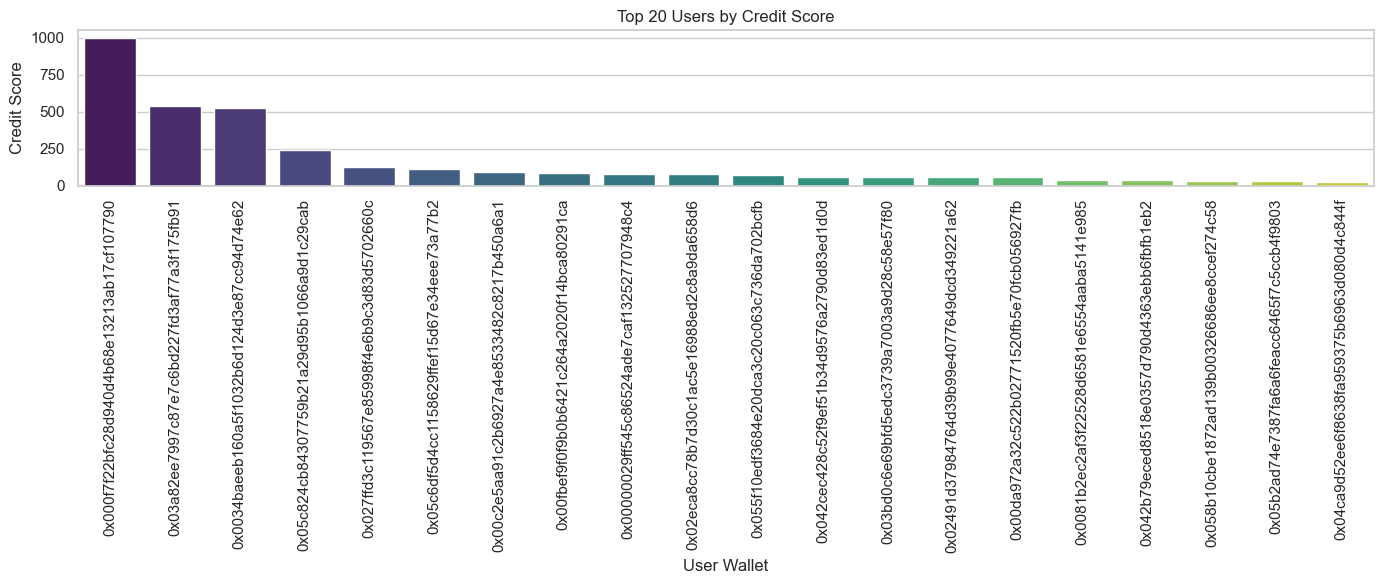

In [119]:
top_users = agg_sorted.head(20)
plt.figure(figsize=(14,6))
sns.barplot(data=top_users, x='userWallet', y='credit_score', palette='viridis')
plt.xticks(rotation=90)
plt.title('Top 20 Users by Credit Score')
plt.ylabel('Credit Score')
plt.xlabel('User Wallet')
plt.tight_layout()
plt.show()
